# CIFAR10 Training

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

# custom imports
from context import LocalLearning

In [2]:
pSet = LocalLearning.LocalLearningModel.pSet
pSet["in_size"] = 32**2 * 3 # CIFAR10 consists of 32x32 pixel 3 channel coloured images
pSet["tau_l"] = 1.0 / 0.02 # learning rate 0.04 leads to nans in model.W
pSet

{'in_size': 3072,
 'hidden_size': 2000,
 'n': 4.5,
 'p': 3,
 'tau_l': 50.0,
 'k': 7,
 'Delta': 0.4,
 'R': 1.0}

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
training_data = datasets.CIFAR10(
    root="../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    training_data, batch_size=128, num_workers=10, shuffle=True
)

Files already downloaded and verified


In [7]:
model = LocalLearning.LocalLearningModel(pSet)
model.to(device)

NO_EPOCHS = 100

def learning_rate(epoch: int) -> float:
    return (NO_EPOCHS - epoch)*0.02 / NO_EPOCHS
 
LocalLearning.train_unsupervised(dataloader_train, model, device, no_epochs=NO_EPOCHS, learning_rate=learning_rate)

Epoch: 99: 100%|███████████████████████████████████████████████████████████████████████████████████| 391/391 [00:55<00:00,  7.06batch/s]


In [8]:
model_path = Path("../data/models/CIFAR10_locallearner.pth")
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "model_parameters": model.param_dict(),
        "device_type": device.type
    },
    model_path
)

# Inference and Spectrum

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/CIFAR10_locallearner.pth")

In [3]:
test_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_inference = DataLoader(
    test_data, batch_size=64, num_workers=4, shuffle=False
)

Files already downloaded and verified


In [10]:
with torch.no_grad():
    trained_state = torch.load(model_path)
    model_ps = trained_state["model_parameters"]
    inf_model = LocalLearning.LocalLearningModel(model_ps)
    inf_model.load_state_dict(trained_state["model_state_dict"])
    inf_model.to(device)
    l_spectrum = LocalLearning.Statistics.cov_spectrum(dataloader_inference, inf_model, device)
    cpu = torch.device('cpu')
    l_spectrum = l_spectrum.to(cpu).numpy()

Calculating covariance spectrum: 100%|████████████████████████████████████████████████████████████| 782/782 [00:01<00:00, 424.63batch/s]


Text(0.5, 1.0, 'CIFAR10 Covariance Spectrum')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


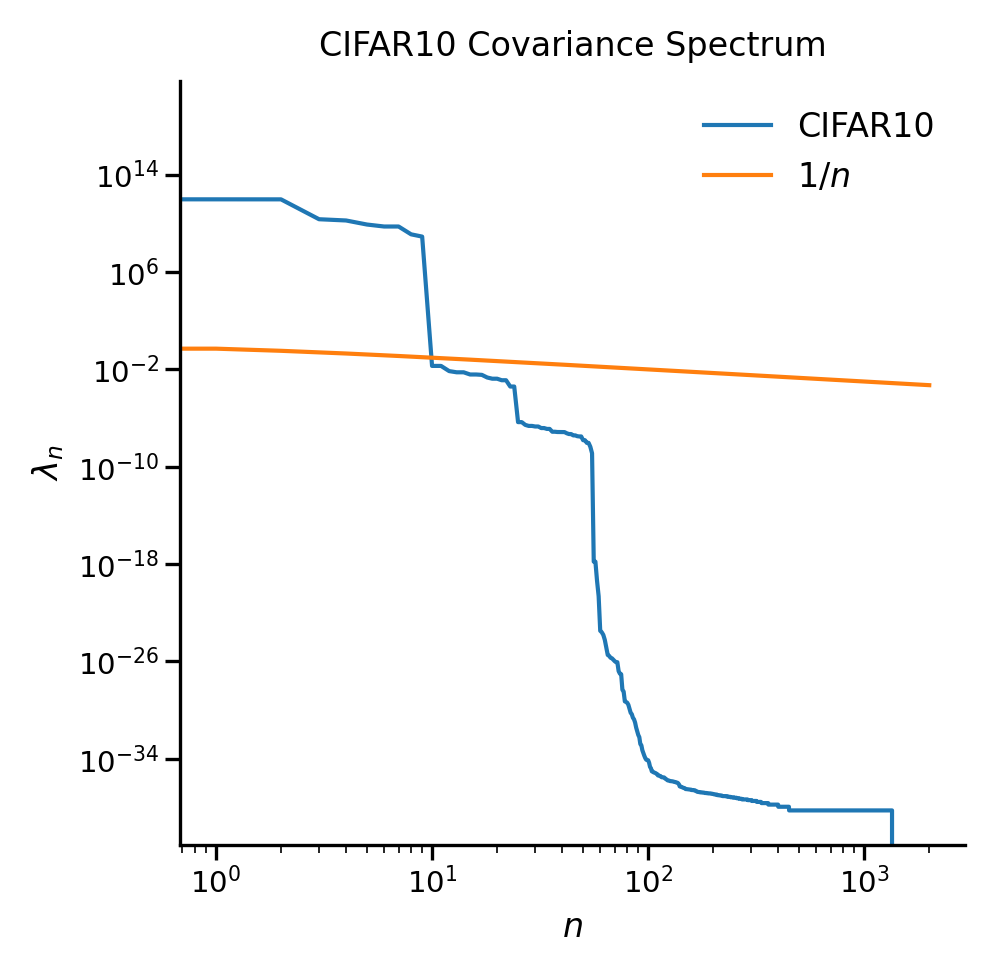

In [11]:
from matplotlib import pyplot as plt
import numpy as np

plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])

fig, ax = plt.subplots()
ax.loglog(l_spectrum, label=r"CIFAR10")
ax.loglog(LocalLearning.stringer_spectrum(np.arange(1, len(l_spectrum))), label=r"$1 / n$")
ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lambda_{n}$")
ax.set_title(r"CIFAR10 Covariance Spectrum")

# Biological Learning Model

In [2]:
test_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_inference = DataLoader(
    test_data, batch_size=64, num_workers=4, shuffle=False
)

Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/CIFAR10_locallearner.pth")
ll_trained_state = torch.load(model_path)
bio_model = LocalLearning.BioLearningModel(ll_trained_state)